In [46]:
%matplotlib inline

import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import scipy as spy
import qgrid

from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

import itertools
import sys

sys.path.append("../..")
from networkentropy import network_energy as ne, network_energy_gradient as neg, network_utils as nu

## Correlaction between energy gradient and length of the shortest path for all node pairs
### For sythetic networks

#### Define constants

In [47]:
GENERATORS = ['random', 'smallworld', 'waxman', 'powerlaw']
RANDOM, SMALLWORLD, WAXMAN, POWERLAW = GENERATORS

METHODS = ['randic', 'laplacian', 'graph']
RANDIC, LAPLACIAN, GRAPH = METHODS

PARAMETER_MAX = 4
PARAMETERS = list(range(1, PARAMETER_MAX)) #parameters for synthetic networks models

#### Create synthetic networks

In [48]:
def create_graph(p, generator, p_max, num_nodes=100):
    if generator == RANDOM:
        return nx.erdos_renyi_graph(n=num_nodes, p=p/(p_max*10))
    elif generator == SMALLWORLD:
        return nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/p_max)
    elif generator == WAXMAN:
        return nx.waxman_graph(n=num_nodes, alpha=p/p_max, beta=0.1)
    elif generator == POWERLAW:
        return nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/(p_max*10))
    else:
        raise ValueError('Generator: {} does not exist'.format(generator))

In [49]:
def create_graphs(paramters, parameter_max, generators):
    graphs = []
    parameters_generators = list(itertools.product(paramters, generators))
    for p, generator in tqdm(parameters_generators):
        graph = create_graph(p, generator, parameter_max)
        graphs.append(OrderedDict([('param', p), 
                                   ('generator', generator), 
                                   ('graph', graph),]))
    return pd.DataFrame(graphs)

In [50]:
graphs_df = create_graphs(PARAMETERS, PARAMETER_MAX, GENERATORS)

In [51]:
graphs_df.head()

,param,generator,graph
0,1,random,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,smallworld,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,1,waxman,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,1,powerlaw,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,2,random,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


#### Coalculate shortest paths and gradients for the networks

In [52]:
def compute_shortest_paths_and_gradients_for_graph(graph: nx.Graph, additional_attrs: dict, methods):
    shortest_paths = nx.shortest_path(graph)
    decorated_graph = neg.get_graph_with_energy_data(graph, methods, copy=False)
    results = []
    for source, paths in shortest_paths.items():
        for target, path in paths.items():
            length = len(path) - 1
            if length > 0:
                for method in methods:
                    gradient = decorated_graph.get_gradient(source, target, method)
                    path_energy = decorated_graph.get_path_energy(path, method)
                    row = OrderedDict(additional_attrs)
                    row.update(OrderedDict([('method', method), 
                                            ('source', source), 
                                            ('target', target), 
                                            ('length', length), 
                                            ('gradient', gradient),
                                            ('abs_gradient', np.abs(gradient)),
                                            ('path_energy', path_energy),
                                            ('avg_path_energy', path_energy/len(path)),]))
                    results.append(row)
    return results
    

def compute_shortest_paths_and_gradients_for_synthetic_networks(graphs_df, methods):
    results = []
    for _, (p, generator, graph) in tqdm(list(graphs_df.iterrows())):
        additional_attrs = OrderedDict([('param', p),
                                        ('generator', generator),])
        results.extend(compute_shortest_paths_and_gradients_for_graph(graph, additional_attrs, methods))
    return pd.DataFrame(results)

In [53]:
paths_data_df = compute_shortest_paths_and_gradients_for_synthetic_networks(graphs_df, METHODS)

In [91]:
qgrid.show_grid(paths_data_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Check is data destribution is normal

In [55]:
def draw_qqplot(data):
    qqplot(data, line='s')
    pyplot.show()

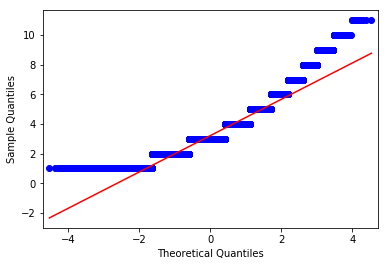

In [56]:
draw_qqplot(paths_data_df.length)

In [57]:
spy.stats.normaltest(paths_data_df.length)

NormaltestResult(statistic=40004.89749695716, pvalue=0.0)

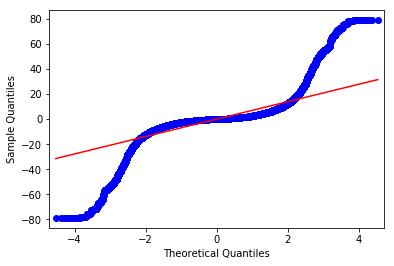

In [58]:
draw_qqplot(paths_data_df.gradient)

In [59]:
spy.stats.normaltest(paths_data_df.gradient)

NormaltestResult(statistic=100704.40825779282, pvalue=0.0)

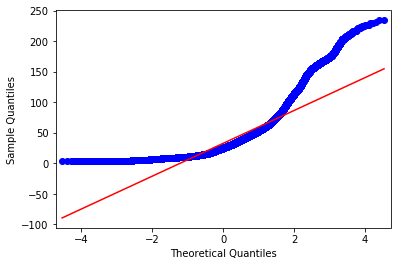

In [60]:
draw_qqplot(paths_data_df.path_energy)

In [61]:
spy.stats.normaltest(paths_data_df.path_energy)

NormaltestResult(statistic=152106.7616601349, pvalue=0.0)

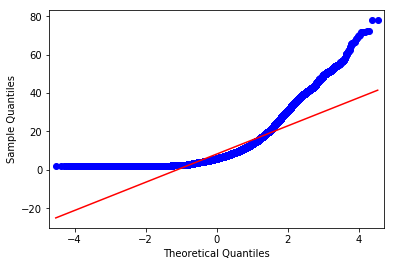

In [62]:
draw_qqplot(paths_data_df.avg_path_energy)

In [63]:
spy.stats.normaltest(paths_data_df.avg_path_energy)

NormaltestResult(statistic=163268.65871026096, pvalue=0.0)

##### Conclusion

Results clearly show the data is not normally distributed for all of the analyzed columns. It is visible on qqplot and also p value of statistical test is zero or very near to zero for all the columns. 

#### Calculate correlations between shortest path lengths and energy gradients

In [64]:
def compute_correlation(grouped_df, column1, column2, methods):
    corr_series = []    
    for method in methods:
        df = grouped_df.corr(method=method)
        index_len = len(df.index.names)
        index_slices = (index_len - 1) * (slice(None),) + (column1,)
        series = df.loc[index_slices, column2]
        series.name = method
        corr_series.append(series)
    corr_df =  pd.concat(corr_series, axis=1)
    corr_df.index = corr_df.index.droplevel(-1)
    return corr_df

def compute_correlation_for_synthetic_networks(paths_gradients_df, column1, column2, methods=['pearson', 'kendall', 'spearman']):
    grouped_df = paths_gradients_df\
                    .query('target > source')\
                    .loc[:, ['method', 'generator', 'param', column1, column2]]\
                    .groupby(['method', 'generator', 'param'])
    return compute_correlation(grouped_df, column1, column2, methods)

In [65]:
length_abs_gradient_corr_df = compute_correlation_for_synthetic_networks(paths_data_df, 'length', 'abs_gradient')
qgrid.show_grid(length_abs_gradient_corr_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [66]:
path_energy_length_corr_df = compute_correlation_for_synthetic_networks(paths_data_df, 'length', 'path_energy')
qgrid.show_grid(path_energy_length_corr_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [67]:
avg_path_energy_length_corr_df = compute_correlation_for_synthetic_networks(paths_data_df, 'length', 'avg_path_energy')
qgrid.show_grid(avg_path_energy_length_corr_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

##### Conclusion

We can observe small correlation for gradient and average path energy, however its maximum values are about -0.35.
There is a very high correlation between path energy and length of the shortest path but these measures are dependent as sum for longer element has more elements so this probably doesn't bring much information.

#### Calculate it again using custom function

It is redundant repetition but I leave it for now

In [68]:
def compute_correlations(parameters, generators, methods, paths_gradients_df):
    correlations = []
    for p, generator, method in tqdm(list(itertools.product(parameters, generators, methods))):
        sub_df = paths_gradients_df.query("param=='{}' and generator=='{}' and method=='{}'".format(p, generator, method))
        #leave out negative equivalents
        sub_df = sub_df.query("target > source")
        sub_df = sub_df.assign(abs_gradient=np.abs(sub_df.gradient))
        x = list(sub_df.length)
        y = list(sub_df.abs_gradient)
        corr = spy.stats.pearsonr(x, y)
        correlations.append(OrderedDict([('p', p), 
                                         ('generator', generator), 
                                         ('method', method), 
                                         ('corr', corr)]))
    return pd.DataFrame(correlations)

In [69]:
corr_df2 = compute_correlations(PARAMETERS, GENERATORS, METHODS, paths_data_df)
qgrid.show_grid(corr_df2.sort_values('corr').head())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### For empirical networks

In [70]:
datasets = nu.create_datasets('konect.uni').filter(min_size=50, max_size=500, max_density=0.1)

In [71]:
datasets.to_df().head()

,name,category,num_nodes,num_edges,tsv_url
8,brunson_revolution,Affiliation,141,160,http://konect.uni-koblenz.de/downloads/tsv/bru...
27,arenas-meta,Metabolic,453,4596,http://konect.uni-koblenz.de/downloads/tsv/are...
45,adjnoun_adjacency,Lexical,112,425,http://konect.uni-koblenz.de/downloads/tsv/adj...
66,dolphins,Animal,62,159,http://konect.uni-koblenz.de/downloads/tsv/dol...
102,moreno_highschool,HumanSocial,70,366,http://konect.uni-koblenz.de/downloads/tsv/mor...


In [72]:
list(nu.create_datasets('konect.uni').to_df().query("name=='brunson_south-africa'").tsv_url)

['http://konect.uni-koblenz.de/downloads/tsv/brunson_south-africa.tar.bz2']

In [73]:
networks_df = datasets.download_and_build_networks('data/')

In [74]:
def compute_shortest_paths_and_gradients_for_empirical_networks(networks_df: pd.DataFrame, methods):
    results = []
    for _, (name, category, _, _, _, graph) in tqdm(list(networks_df.iterrows())):
        print(name)
        additional_attrs = OrderedDict([('name', name),                                        
                                        ('category', category),])
        results.extend(compute_shortest_paths_and_gradients_for_graph(graph, additional_attrs, methods))
    return pd.DataFrame(results)

In [75]:
paths_data_empirical_df = compute_shortest_paths_and_gradients_for_empirical_networks(networks_df, METHODS)

brunson_revolution
arenas-meta
adjnoun_adjacency
dolphins
moreno_highschool
arenas-jazz
moreno_lesmis
maayan-foodweb
maayan-pdzbase
moreno_innovation
moreno_oz
moreno_train



In [76]:
paths_data_empirical_df.head()

,name,category,method,source,target,length,gradient,abs_gradient,path_energy,avg_path_energy
0,brunson_revolution,Affiliation,randic,1,2,1,-1.103743,1.103743,7.903992,3.951996
1,brunson_revolution,Affiliation,laplacian,1,2,1,-102.239354,102.239354,198.054556,99.027278
2,brunson_revolution,Affiliation,graph,1,2,1,-11.847054,11.847054,41.850103,20.925052
3,brunson_revolution,Affiliation,randic,1,3,1,-0.506857,0.506857,8.500879,4.250439
4,brunson_revolution,Affiliation,laplacian,1,3,1,-81.782711,81.782711,218.511199,109.255600


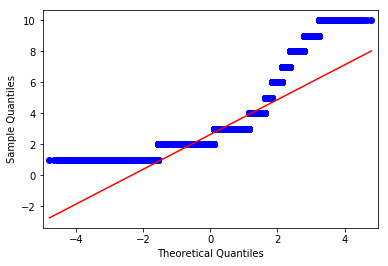

In [77]:
draw_qqplot(paths_data_empirical_df.length)

In [78]:
spy.stats.normaltest(paths_data_empirical_df.length)

NormaltestResult(statistic=578633.1967249401, pvalue=0.0)

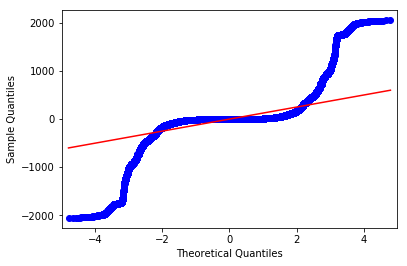

In [79]:
draw_qqplot(paths_data_empirical_df.gradient)

In [80]:
spy.stats.normaltest(paths_data_empirical_df.gradient)

NormaltestResult(statistic=475657.98547785985, pvalue=0.0)

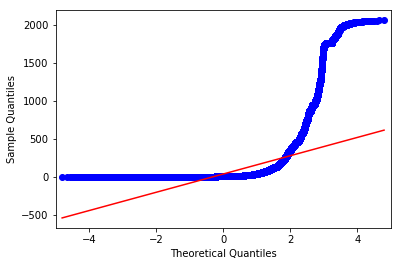

In [81]:
draw_qqplot(paths_data_empirical_df.abs_gradient)

In [82]:
spy.stats.normaltest(paths_data_empirical_df.abs_gradient)

NormaltestResult(statistic=1753627.8888022795, pvalue=0.0)

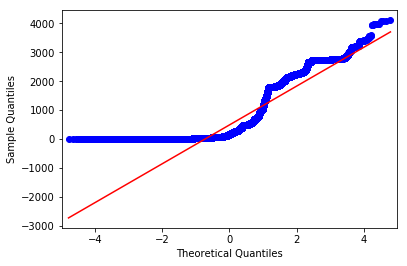

In [83]:
draw_qqplot(paths_data_empirical_df.path_energy)

In [84]:
spy.stats.normaltest(paths_data_empirical_df.path_energy)

NormaltestResult(statistic=331064.7917593766, pvalue=0.0)

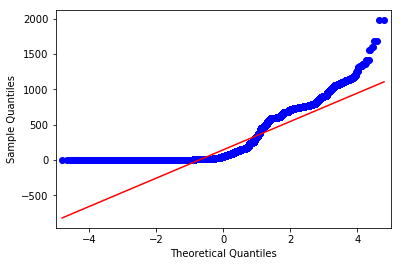

In [85]:
draw_qqplot(paths_data_empirical_df.avg_path_energy)

In [86]:
spy.stats.normaltest(paths_data_empirical_df.avg_path_energy)

NormaltestResult(statistic=364920.9860340892, pvalue=0.0)

In [87]:
def compute_correlation_for_empirical_networks(paths_gradients_df, column1, column2, methods=['pearson', 'kendall', 'spearman']):
    grouped_df = paths_gradients_df\
                    .query('target > source')\
                    .loc[:, ['category', 'name', 'method', column1, column2,]]\
                    .groupby(['category', 'name', 'method',])
    return compute_correlation(grouped_df, column1, column2, methods)

In [88]:
length_abs_gradient_corr_empirical_df = \
compute_correlation_for_empirical_networks(paths_data_empirical_df,  'length', 'abs_gradient')
qgrid.show_grid(length_abs_gradient_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [89]:
length_path_energy_corr_empirical_df = \
compute_correlation_for_empirical_networks(paths_data_empirical_df,  'length', 'path_energy')
qgrid.show_grid(length_path_energy_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [90]:
length_avg_path_energy_corr_empirical_df = \
compute_correlation_for_empirical_networks(paths_data_empirical_df,  'length', 'avg_path_energy')
qgrid.show_grid(length_avg_path_energy_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…